<a href="https://colab.research.google.com/github/190905186/Automation-scripts/blob/main/license_plate_number_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Get the Yolov5 object detection model

In [1]:
!git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 17564, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 17564 (delta 33), reused 7 (delta 7), pack-reused 17510 (from 4)
Receiving objects: 100% (17564/17564), 16.69 MiB | 16.20 MiB/s, done.
Resolving deltas: 100% (12031/12031), done.


In [2]:
cd yolov5/

/content/yolov5


In [3]:
pip install -r requirements.txt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.5 MB/s eta 0:00:00


Get the ALPR benchmark dataset for the license plate images

In [4]:
# Step 1: Clone the OpenALPR benchmark dataset
%cd ..
!git clone https://github.com/openalpr/benchmarks.git

/content
Cloning into 'benchmarks'...
remote: Enumerating objects: 1752, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 1752 (delta 22), reused 22 (delta 22), pack-reused 1728 (from 1)
Receiving objects: 100% (1752/1752), 187.98 MiB | 19.14 MiB/s, done.
Resolving deltas: 100% (35/35), done.


In [5]:
import os
import cv2
from pathlib import Path

# Create dataset folder outside yolov5
base_dir = '/content/datasets/license_plates'
os.makedirs(f'{base_dir}/images/train', exist_ok=True)
os.makedirs(f'{base_dir}/labels/train', exist_ok=True)


convert annotations to yolo format

In [6]:
import os
import cv2

base_src_dir = '/content/benchmarks/endtoend'
regions = ['us', 'eu', 'br']  # Add more if available

# Output folders
base_dir = '/content/datasets/license_plates'
img_out_dir = os.path.join(base_dir, 'images/train')
label_out_dir = os.path.join(base_dir, 'labels/train')

os.makedirs(img_out_dir, exist_ok=True)
os.makedirs(label_out_dir, exist_ok=True)

def convert_to_yolo(x, y, w, h, img_w, img_h):
    x_center = (x + w / 2) / img_w
    y_center = (y + h / 2) / img_h
    width = w / img_w
    height = h / img_h
    return [0, x_center, y_center, width, height]

for region in regions:
    src_dir = os.path.join(base_src_dir, region)
    print(f"Processing region: {region}, folder: {src_dir}")

    for file in os.listdir(src_dir):
        if not file.endswith('.jpg'):
            continue

        img_path = os.path.join(src_dir, file)
        label_path = os.path.join(src_dir, file.replace('.jpg', '.txt'))

        if not os.path.exists(label_path):
            print(f"Annotation file missing for {file} in {region}, skipping...")
            continue

        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to load image {file} in {region}, skipping...")
            continue

        h_img, w_img = img.shape[:2]

        with open(label_path, 'r') as f:
            line = f.readline().strip()

        parts = line.split('\t')
        if len(parts) < 6:
            print(f"Invalid annotation format in {label_path}, skipping...")
            continue

        try:
            x = int(parts[1])
            y = int(parts[2])
            w = int(parts[3])
            h = int(parts[4])
        except ValueError:
            print(f"Invalid bbox values in {label_path}, skipping...")
            continue

        yolo_box = convert_to_yolo(x, y, w, h, w_img, h_img)

        # Save image - to avoid filename clashes, prepend region to filename
        out_img_name = f"{region}_{file}"
        out_label_name = f"{region}_{file.replace('.jpg', '.txt')}"

        cv2.imwrite(os.path.join(img_out_dir, out_img_name), img)

        out_label_path = os.path.join(label_out_dir, out_label_name)
        with open(out_label_path, 'w') as f:
            f.write(" ".join(f"{v:.6f}" for v in yolo_box) + "\n")

print("All regions processed successfully.")


Processing region: us, folder: /content/benchmarks/endtoend/us
Processing region: eu, folder: /content/benchmarks/endtoend/eu
Processing region: br, folder: /content/benchmarks/endtoend/br
All regions processed successfully.


In [7]:
cat /content/datasets/license_plates/labels/train/br_AYO9034.txt

0.000000 0.475781 0.608333 0.126562 0.072222


splitting up the images into val and train

In [8]:
import os
import shutil
import random

src_img_dir = '/content/datasets/license_plates/images/train'
src_label_dir = '/content/datasets/license_plates/labels/train'

base_dir = '/content/datasets/license_plates'
train_img_dir = os.path.join(base_dir, 'images/train')
val_img_dir = os.path.join(base_dir, 'images/val')
train_label_dir = os.path.join(base_dir, 'labels/train')
val_label_dir = os.path.join(base_dir, 'labels/val')

# Create val folders
os.makedirs(val_img_dir, exist_ok=True)
os.makedirs(val_label_dir, exist_ok=True)

# List all images
all_images = [f for f in os.listdir(src_img_dir) if f.endswith('.jpg')]
random.shuffle(all_images)

split_ratio = 0.8
split_idx = int(len(all_images) * split_ratio)

train_files = all_images[:split_idx]
val_files = all_images[split_idx:]

# Move validation images and labels
for file in val_files:
    # Move image
    shutil.move(os.path.join(src_img_dir, file), os.path.join(val_img_dir, file))
    # Move label
    label_file = file.replace('.jpg', '.txt')
    shutil.move(os.path.join(src_label_dir, label_file), os.path.join(val_label_dir, label_file))

print(f"Train images: {len(train_files)}")
print(f"Validation images: {len(val_files)}")


Train images: 355
Validation images: 89


creating the yaml file for training

In [9]:
# Create license_plate.yaml for training
data_yaml = """
train: /content/datasets/license_plates/images/train
val: /content/datasets/license_plates/images/val

nc: 1
names: ['license_plate']
"""

os.makedirs('/content/data', exist_ok=True)
with open('/content/data/license_plate.yaml', 'w') as f:
    f.write(data_yaml.strip())


Train the model now

In [10]:
%cd /content/yolov5
!python train.py --img 640 --batch 16 --epochs 5 --data /content/data/license_plate.yaml --weights yolov5s.pt --cache


/content/yolov5
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-08-29 13:09:11.487799: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756472951.508451    2925 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756472951.514449    2925 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for 

cropping the images and using tessaract-ocr to get the license plate numbers

In [11]:
!apt-get install -y tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


Inferencing using the model trained and running tesseract on the cropped images.

In [12]:
import torch
import cv2
import os
from pathlib import Path
from PIL import Image
import pytesseract
import matplotlib.pyplot as plt

# Load YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/yolov5/runs/train/exp/weights/best.pt')

# Paths
input_dir = '/content/benchmarks/endtoend/usimages'
output_crop_dir = '/content/cropped_license_plates'
os.makedirs(output_crop_dir, exist_ok=True)

# OCR config
ocr_config = '--psm 7'  # Single text line

cropped_images = []
ocr_texts = []

# Process images until we get 5 crops
for img_file in os.listdir(input_dir):
    if len(cropped_images) >= 5:
        break
    if not img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue
    img_path = os.path.join(input_dir, img_file)
    img = cv2.imread(img_path)
    results = model(img)
    detections = results.xyxy[0].cpu().numpy()

    if len(detections) == 0:
        continue

    # Take only the first detection from this image for demo
    x1, y1, x2, y2, conf, cls = detections[0]
    x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
    crop_img = img[y1:y2, x1:x2]

    # Save cropped image (optional)
    crop_filename = f'{Path(img_file).stem}_plate_0.jpg'
    crop_path = os.path.join(output_crop_dir, crop_filename)
    cv2.imwrite(crop_path, crop_img)

    # OCR
    pil_img = Image.fromarray(cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB))
    text = pytesseract.image_to_string(pil_img, config=ocr_config).strip()

    cropped_images.append(pil_img)
    ocr_texts.append(text if text else "(no text)")

# Plot the cropped images and their OCR results
plt.figure(figsize=(8, 12))
for i, (crop_img, text) in enumerate(zip(cropped_images, ocr_texts)):
    plt.subplot(len(cropped_images)*2, 1, 2*i + 1)
    plt.imshow(crop_img)
    plt.axis('off')
    plt.title(f'Cropped Plate {i+1}')

    plt.subplot(len(cropped_images)*2, 1, 2*i + 2)
    plt.text(0.5, 0.5, text, fontsize=14, ha='center', va='center')
    plt.axis('off')

plt.tight_layout()
plt.show()


/usr/local/lib/python3.12/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(


Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


YOLOv5 🚀 2025-8-29 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecate

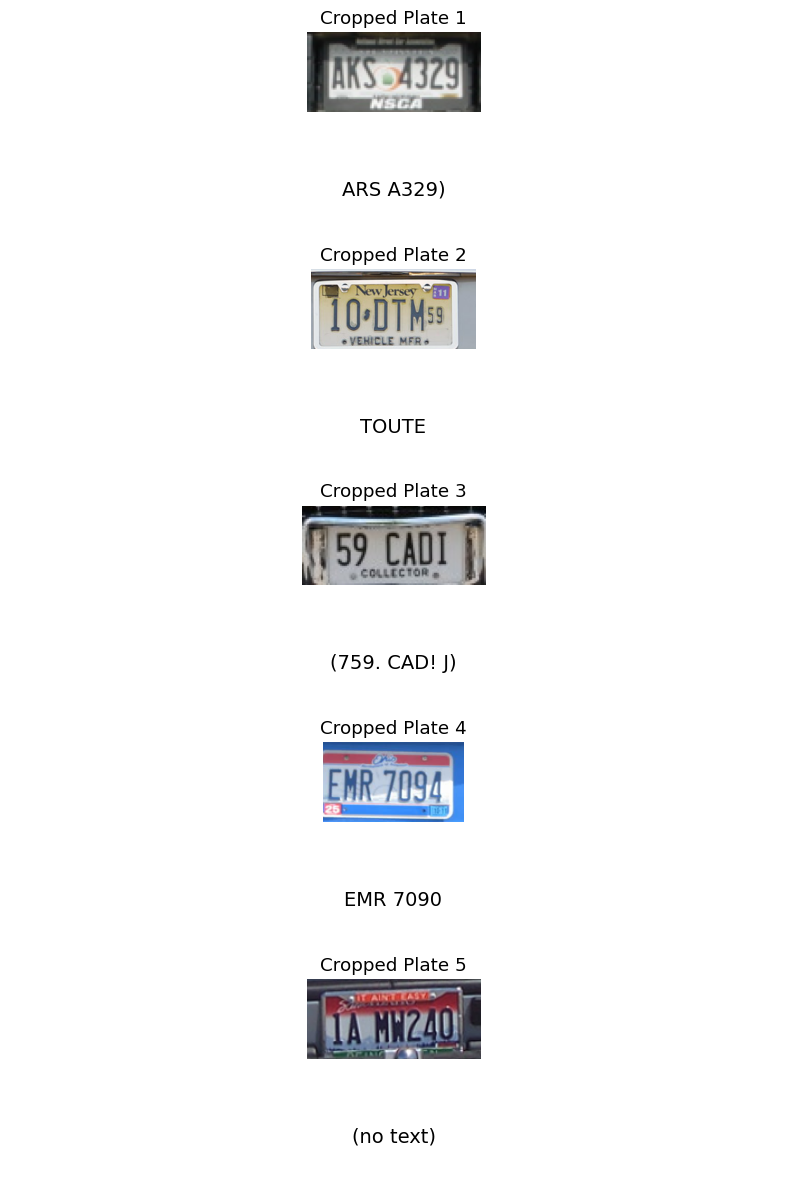

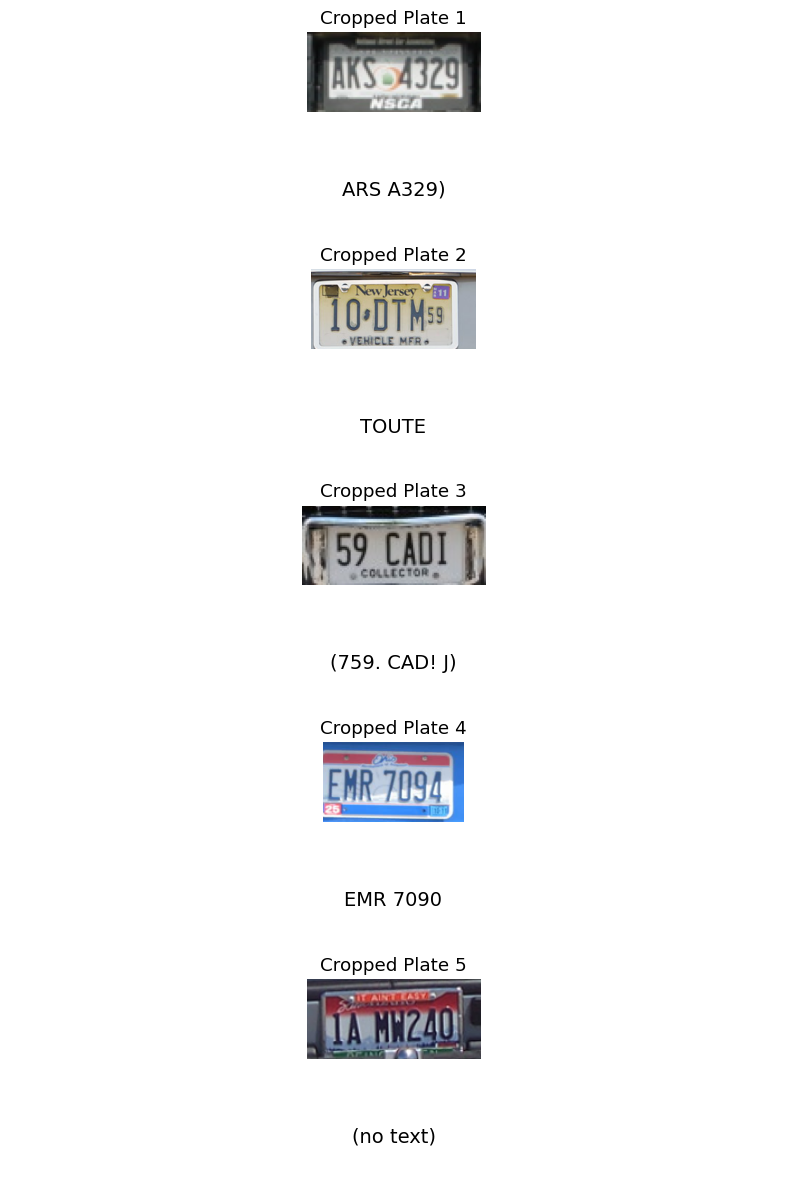

In [13]:
%matplotlib inline

plt.figure(figsize=(8, 12))
for i, (crop_img, text) in enumerate(zip(cropped_images, ocr_texts)):
    plt.subplot(len(cropped_images)*2, 1, 2*i + 1)
    plt.imshow(crop_img)
    plt.axis('off')
    plt.title(f'Cropped Plate {i+1}')

    plt.subplot(len(cropped_images)*2, 1, 2*i + 2)
    plt.text(0.5, 0.5, text, fontsize=14, ha='center', va='center')
    plt.axis('off')

plt.tight_layout()
plt.show()




---

# **Overall System Architecture**

```
Input Images (e.g. from /content/benchmarks/endtoend/usimages)
          |
          v
[1] License Plate Detection (YOLOv5 Model)
          |
          v
[2] Crop detected license plate regions
          |
          v
[3] Optical Character Recognition (OCR) on cropped plates (Tesseract)
          |
          v
[4] Output recognized license plate texts + optionally save crops & visualize results
```

---

## Detailed Component Breakdown

### 1. **License Plate Detection**

* **Model:** YOLOv5 (custom trained on license plate dataset)
* **Input:** Full-size images
* **Output:** Bounding boxes with class confidence for license plates
* **Purpose:** Localize license plate regions in the input images
* **Implementation:**

  * Load trained weights (e.g., `best.pt`)
  * Perform inference to get bounding boxes `[x1, y1, x2, y2, conf, class]`

---

### 2. **Cropping Detected Plates**

* **Input:** Bounding boxes from YOLOv5 output
* **Operation:** Use bounding box coordinates to crop the license plate area from the original image
* **Output:** Cropped license plate images, ready for OCR

---

### 3. **Optical Character Recognition (OCR)**

* **Tool:** Tesseract OCR
* **Input:** Cropped license plate images
* **Output:** Extracted text strings representing the license plate numbers
* **Operation details:**

  * Convert cropped image to PIL format (RGB)
  * Apply Tesseract OCR with suitable configuration (e.g., `--psm 7` for single line text)
  * Get string output with detected alphanumeric characters

---

### 4. **Postprocessing and Visualization**

* **Actions:**

  * Save cropped plate images (optional)
  * Print or save recognized license plate texts
  * Visualize crops along with OCR predictions stacked vertically
  * Potentially store results in CSV or database for downstream use

---

## Optional Extensions

* **Data augmentation** during training to improve detection robustness (rotations, brightness, noise, etc.)
* **OCR confidence filtering** or error correction on Tesseract outputs
* **Integration with video streams** for real-time detection + recognition
* **End-to-end training** combining detection + recognition with more advanced OCR models

---

# Summary

| Step                  | Input                   | Output                          | Tools/Models          |
| --------------------- | ----------------------- | ------------------------------- | --------------------- |
| 1. Detection          | Full image              | Bounding boxes for plates       | YOLOv5 custom model   |
| 2. Cropping           | Image + bounding boxes  | Cropped license plate images    | OpenCV / Pillow       |
| 3. OCR                | Cropped plates          | Text strings of license numbers | Tesseract OCR         |
| 4. Visualization/Save | Crops + recognized text | Visual output & saved files     | matplotlib / file I/O |

---



utility to see the images present in the any path

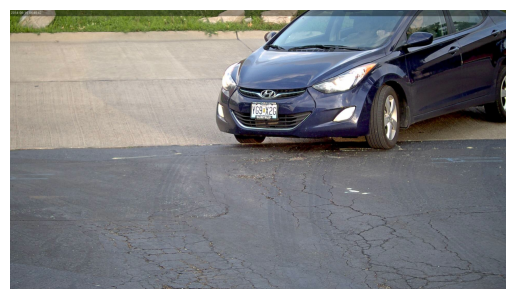

In [14]:
# pass the image path and the image will be displayed
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open('/content/benchmarks/endtoend/us/0b86cecf-67d1-4fc0-87c9-b36b0ee228bb.jpg')

plt.imshow(img)
plt.axis('off')  # Hide axes ticks
plt.show()


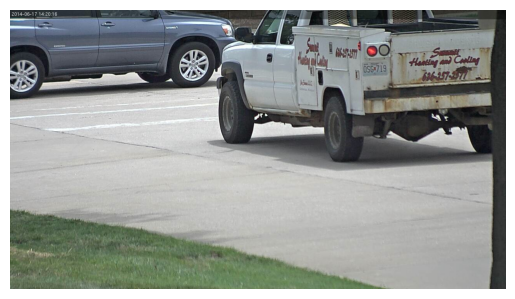

In [ ]:
img = Image.open('/content/benchmarks/endtoend/us/12c6cb72-3ea3-49e7-b381-e0cdfc5e8960.jpg')

plt.imshow(img)
plt.axis('off')  # Hide axes ticks
plt.show()


In [15]:
import torch
import cv2
import numpy as np
from PIL import Image
import pytesseract
import matplotlib.pyplot as plt

def detect_license_plate_and_ocr(image_path, model_path='/content/yolov5/runs/train/exp/weights/best.pt'):
    """
    Detects the license plate in a car image using YOLOv5 and performs OCR using Tesseract.

    Parameters:
    - image_path (str): Path to the car image
    - model_path (str): Path to the trained YOLOv5 model weights

    Returns:
    - plate_text (str): Detected license plate text
    """
    # Load YOLOv5 model
    model = torch.hub.load('ultralytics/yolov5', 'custom', path=model_path, force_reload=True)

    # Load the car image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image from {image_path}")
        return None

    # Run detection
    results = model(image)
    df = results.pandas().xyxy[0]

    if df.empty:
        print("No license plate detected.")
        return None

    # Process the first detected license plate
    row = df.iloc[0]
    x1, y1, x2, y2 = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
    plate_img = image[y1:y2, x1:x2]

    # Convert to RGB for Tesseract
    plate_pil = Image.fromarray(cv2.cvtColor(plate_img, cv2.COLOR_BGR2RGB))

    # OCR using Tesseract
    plate_text = pytesseract.image_to_string(plate_pil, config='--psm 7').strip()

    # Display results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(plate_pil)
    plt.title(f"Detected Plate: {plate_text}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return plate_text


Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


YOLOv5 🚀 2025-8-29 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


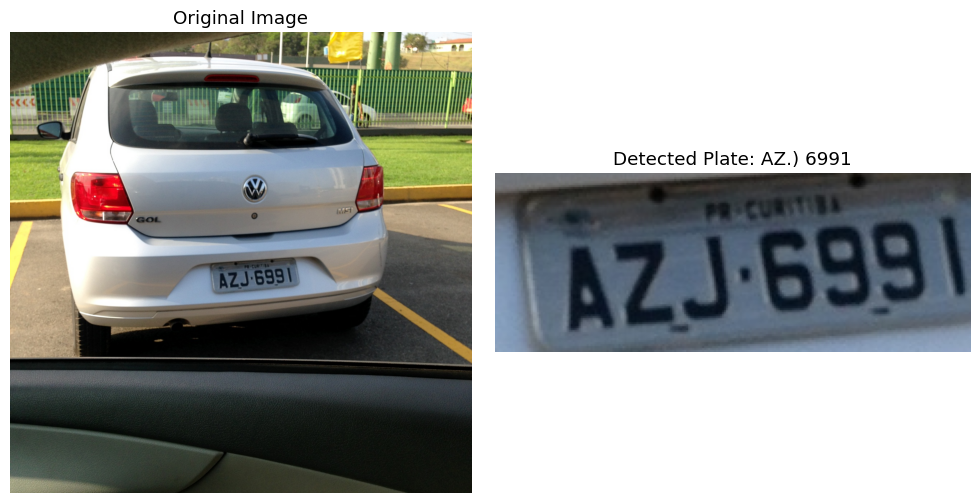

License Plate Text: AZ.) 6991


In [17]:
# pass the image here to see the original iamge , license plate image and the detected license plate number
text = detect_license_plate_and_ocr('/content/datasets/license_plates/images/train/br_AZJ6991.jpg')
print("License Plate Text:", text)
